# 🤖 Dynamic LangGraph RAG System

**TRULY DYNAMIC VERSION** - No hardcoded queries anywhere!

**Key Features:**
- ✅ User input drives everything
- ✅ State generates queries dynamically
- ✅ Each node refines based on previous results
- ✅ No pre-programmed questions
- ✅ Intelligent query refinement

In [1]:
# Setup
import os
import asyncio
from dotenv import load_dotenv
from typing import TypedDict, List, Dict, Any, Optional
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.documents import Document

load_dotenv()
print("✅ Environment loaded")
print(f"📁 Working in: {os.getcwd()}")

✅ Environment loaded
📁 Working in: /home/oh/Documents/ai-content-platform/notebook


## Dynamic State Schema

In [2]:
class DynamicState(TypedDict):
    """Dynamic state """
    messages: List[BaseMessage]
    
    # User input (the ONLY thing that drives the system)
    user_question: str
    
    # Dynamic query generation
    current_research_focus: str
    generated_queries: List[str]
    query_generation_reasoning: List[str]
    
    # Research results
    rag_findings: List[Dict[str, Any]]  # Each with query, results, analysis
    web_findings: List[Dict[str, Any]]  # Each with query, results, analysis
    
    # State-based decisions
    information_gaps: List[str]
    next_research_strategy: str
    research_iteration: int
    max_iterations: int
    
    # Human-in-the-loop additions
    human_in_loop: bool
    human_queries: List[str]
    human_decision: str  # "continue" or "synthesize"
    
    # Final synthesis
    synthesized_answer: str
    confidence_score: float
    
    # Complete transparency
    decision_log: List[str]
    state_transitions: List[str]

print("🏗️ Dynamic state schema - NO HARDCODED QUERIES!")
print("📋 User input drives EVERYTHING!")
print("🤖 Human-in-the-loop capability added!")

🏗️ Dynamic state schema - NO HARDCODED QUERIES!
📋 User input drives EVERYTHING!
🤖 Human-in-the-loop capability added!


## Setup Document Processing

In [3]:
# Load and process documents (same as before)
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_ollama.embeddings import OllamaEmbeddings
from langchain_chroma import Chroma

def setup_document_system():
    """Setup document system once"""
    print("📄 Setting up document system...")
    
    file_path = "../data/Fabrinet Investor Deck Feb 2025.pdf"
    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        return None
    
    # Load and chunk ALL documents
    loader = PyPDFLoader(file_path)
    docs = loader.load()
    
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=800,
        chunk_overlap=100
    )
    
    chunks = splitter.split_documents(docs)
    
    # Create vector store
    embeddings = OllamaEmbeddings(model="dengcao/Qwen3-Embedding-4B:Q4_K_M")
    vector_store = Chroma(
        collection_name="dynamic_rag",
        embedding_function=embeddings,
        persist_directory="./chroma_dynamic_rag"
    )
    
    ids = vector_store.add_documents(chunks)
    
    print(f"✅ Ready: {len(chunks)} chunks in vector store")
    return vector_store

# Setup once
vector_store = setup_document_system()
print(f"📊 Vector store status: {'Ready' if vector_store else 'Failed'}")

/home/oh/miniconda3/envs/py313/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/oh/miniconda3/envs/py313/lib/python3.13/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


📄 Setting up document system...
✅ Ready: 26 chunks in vector store
📊 Vector store status: Ready


## Dynamic Query Generation Tool

In [4]:
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from ollama import Client

# Initialize LLM and client
llm = ChatOllama(
    model="qwen3:8b",
    temperature=0.1,
    max_tokens=1000,
    base_url="http://localhost:11434"
)

ollama_api_key = os.getenv('OLLAMA_API_KEY')
client = Client(
    host='http://127.0.0.1:11434',
    headers={'Authorization': f'Bearer {ollama_api_key}'}
) if ollama_api_key else None

@tool
def generate_research_queries(user_question: str, previous_findings: str = "", iteration: int = 1) -> str:
    """
    DYNAMIC query generation based on user input and previous findings.
    NO HARDCODED QUERIES - everything generated based on context!
    """
    print(f"\n🧠 Generating queries for: '{user_question}' (iteration {iteration})")
    
    if iteration == 1:
        # First iteration - generate initial broad queries
        prompt = f"""Generate 3-4 specific search queries to research: "{user_question}"

Rules:
1. Queries should be specific and search-friendly
2. Include different angles and keywords
3. Each query should be on a new line
4. No explanations, just queries

Example format:
specific search term 1
alternative search term 2
related search term 3"""
    else:
        # Subsequent iterations - refine based on findings
        prompt = f"""Based on previous research findings, generate 2-3 refined search queries to complete research on: "{user_question}"

Previous findings:
{previous_findings[:1000]}...

Generate specific queries to fill information gaps. Focus on:
1. Missing details or specifics
2. Unanswered aspects of the question
3. Different perspectives or angles

Format: One query per line, no explanations."""
    
    try:
        response = llm.invoke(prompt)
        queries = [q.strip() for q in response.content.split('\n') if q.strip()]
        
        print(f"🎯 Generated {len(queries)} dynamic queries:")
        for i, query in enumerate(queries, 1):
            print(f"   {i}. {query}")
        
        return "\n".join(queries)
        
    except Exception as e:
        print(f"❌ Query generation error: {e}")
        return user_question  # Fallback to original question

print("🛠️ Dynamic query generator ready - NO HARDCODING!")

🛠️ Dynamic query generator ready - NO HARDCODING!


## Dynamic Research Tools

In [5]:
@tool
def execute_rag_research(queries: str) -> str:
    """
    Execute RAG research using DYNAMICALLY generated queries.
    """
    if not vector_store:
        return "Vector store not available"
    
    query_list = [q.strip() for q in queries.split('\n') if q.strip()]
    print(f"🔍 Executing RAG research with {len(query_list)} dynamic queries")
    
    all_results = []
    
    for query in query_list:
        print(f"   🔎 RAG Query: {query}")
        try:
            results = vector_store.similarity_search_with_score(query, k=3)
            
            if results:
                relevant_results = []
                for doc, score in results:
                    if score < 1.5:  # Relevant threshold
                        content = doc.page_content.replace('\n', ' ')
                        relevant_results.append(f"(Score: {score:.3f}) {content[:200]}...")
                
                if relevant_results:
                    result_summary = f"Query: {query}\nResults:\n" + "\n".join(relevant_results)
                    all_results.append(result_summary)
                    print(f"      ✅ Found {len(relevant_results)} relevant results")
                else:
                    print(f"      ❌ No relevant results (score > 1.5)")
            else:
                print(f"      ❌ No results found")
                
        except Exception as e:
            print(f"      ❌ RAG error: {e}")
    
    combined_results = "\n\n---\n\n".join(all_results)
    print(f"📊 RAG research complete: {len(combined_results)} characters")
    return combined_results

@tool
def execute_web_research(queries: str) -> str:
    """
    Execute web research using DYNAMICALLY generated queries.
    """
    if not client:
        return "Web search not available"
    
    query_list = [q.strip() for q in queries.split('\n') if q.strip()][:2]  # Limit web queries
    print(f"🌐 Executing web research with {len(query_list)} dynamic queries")
    
    all_results = []
    
    for query in query_list:
        print(f"   🔎 Web Query: {query}")
        try:
            search_result = client.web_search(query=query, max_results=2)
            
            if hasattr(search_result, 'results') and search_result.results:
                results_text = []
                for res in search_result.results:
                    title = getattr(res, 'title', 'No title')
                    content = getattr(res, 'content', 'No content')[:200]
                    results_text.append(f"{title}: {content}")
                
                result_summary = f"Query: {query}\nResults:\n" + "\n".join(results_text)
                all_results.append(result_summary)
                print(f"      ✅ Found {len(search_result.results)} web results")
            else:
                print(f"      ❌ No web results found")
                
        except Exception as e:
            print(f"      ❌ Web search error: {e}")
    
    combined_results = "\n\n---\n\n".join(all_results)
    print(f"📊 Web research complete: {len(combined_results)} characters")
    return combined_results

@tool
def analyze_research_findings(findings: str, original_question: str) -> str:
    """
    Analyze research findings to identify gaps and next steps.
    """
    print(f"📊 Analyzing research findings for: '{original_question}'")
    
    prompt = f"""Analyze these research findings for the question: "{original_question}"

Research Findings:
{findings[:2000]}...

Provide analysis in three parts:
1. KEY_INFORMATION_FOUND: List the main information discovered
2. INFORMATION_GAPS: What important details are still missing?
3. NEXT_RESEARCH_FOCUS: What specific aspects need more research?

Be specific and actionable."""
    
    try:
        response = llm.invoke(prompt)
        print(f"📈 Analysis complete: {len(response.content)} characters")
        return response.content
    except Exception as e:
        print(f"❌ Analysis error: {e}")
        return f"Analysis failed: {e}"

# Human-in-the-loop interaction tools
def display_research_summary(state: DynamicState) -> str:
    """Display a comprehensive summary of all research done so far"""
    print("\n" + "="*80)
    print("🤖 HUMAN-IN-THE-LOOP: RESEARCH SUMMARY")
    print("="*80)
    
    print(f"\n🎯 Original Question: {state['user_question']}")
    print(f"🔄 Current Iteration: {state['research_iteration']}")
    print(f"📊 Total Research Iterations: {state['research_iteration'] - 1}")
    
    # Show all queries tried
    all_queries = []
    for finding in state['rag_findings']:
        iteration = finding['iteration']
        for query in finding['queries']:
            all_queries.append(f"Iteration {iteration}: {query}")
    
    print(f"\n🔍 ALL QUERIES TRIED ({len(all_queries)} total):")
    for i, query in enumerate(all_queries, 1):
        print(f"   {i}. {query}")
    
    # Show research results summary
    print(f"\n📋 RESEARCH RESULTS SUMMARY:")
    
    # RAG findings
    if state['rag_findings']:
        print(f"\n📚 RAG Research Results:")
        total_rag_chars = sum(len(f['results']) for f in state['rag_findings'])
        print(f"   • Total iterations: {len(state['rag_findings'])}")
        print(f"   • Total characters: {total_rag_chars}")
        
        for i, finding in enumerate(state['rag_findings'], 1):
            print(f"   \n   📄 Iteration {finding['iteration']}:")
            print(f"      Queries: {len(finding['queries'])}")
            print(f"      Results: {len(finding['results'])} characters")
            # Show brief preview
            preview = finding['summary'][:200] + "..." if len(finding['summary']) > 200 else finding['summary']
            print(f"      Preview: {preview}")
    
    # Web findings
    if state['web_findings']:
        print(f"\n🌐 Web Research Results:")
        total_web_chars = sum(len(f['results']) for f in state['web_findings'])
        print(f"   • Total iterations: {len(state['web_findings'])}")
        print(f"   • Total characters: {total_web_chars}")
        
        for i, finding in enumerate(state['web_findings'], 1):
            print(f"   \n   🌍 Iteration {finding['iteration']}:")
            print(f"      Queries: {len(finding['queries'])}")
            print(f"      Results: {len(finding['results'])} characters")
            # Show brief preview
            preview = finding['summary'][:200] + "..." if len(finding['summary']) > 200 else finding['summary']
            print(f"      Preview: {preview}")
    
    # Show information gaps
    if state['information_gaps']:
        print(f"\n🕳️ IDENTIFIED INFORMATION GAPS:")
        for gap in state['information_gaps']:
            print(f"   • {gap}")
    else:
        print(f"\n✅ NO SPECIFIC GAPS IDENTIFIED")
    
    # Show human queries already added
    if state['human_queries']:
        print(f"\n👤 HUMAN-ADDED QUERIES:")
        for i, query in enumerate(state['human_queries'], 1):
            print(f"   {i}. {query}")
    
    print("\n" + "="*80)
    return "Research summary displayed"

def get_human_input(state: DynamicState) -> str:
    """
    Interactive function to get human input during research
    """
    print("\n" + "="*80)
    print("🤖 HUMAN-IN-THE-LOOP INTERACTION")
    print("="*80)
    
    print(f"\n📊 Research Status:")
    print(f"   • Iteration: {state['research_iteration']}/{state['max_iterations']}")
    print(f"   • Total queries tried: {len(state['generated_queries']) + len(state['human_queries'])}")
    print(f"   • Research complete: {len(state['rag_findings']) + len(state['web_findings'])} findings")
    
    print(f"\n🎯 YOUR OPTIONS:")
    print(f"   1. Add specific search queries (comma-separated)")
    print(f"   2. Type 'synthesize' to proceed to final synthesis")
    print(f"   3. Type 'continue' for automatic research continuation")
    print(f"   4. Type 'help' for more options")
    
    while True:
        user_input = input(f"\n👤 Your choice: ").strip()
        
        if user_input.lower() == 'synthesize':
            return "synthesize"
        elif user_input.lower() == 'continue':
            return "continue"
        elif user_input.lower() == 'help':
            print(f"\n📖 DETAILED OPTIONS:")
            print(f"   • Add queries: 'query1, query2, query3'")
            print(f"   • Synthesize: 'synthesize' - create final answer now")
            print(f"   • Continue: 'continue' - let AI continue automatically")
            print(f"   • Status: 'status' - show detailed research status")
            print(f"   • Preview: 'preview' - show current research preview")
            continue
        elif user_input.lower() == 'status':
            print(f"\n📊 DETAILED STATUS:")
            print(f"   • RAG findings: {len(state['rag_findings'])}")
            print(f"   • Web findings: {len(state['web_findings'])}")
            print(f"   • Information gaps: {len(state['information_gaps'])}")
            print(f"   • Human queries: {len(state['human_queries'])}")
            continue
        elif user_input.lower() == 'preview':
            # Show a preview of current findings
            all_findings = "\n".join([f["summary"] for f in state.get("rag_findings", []) + state.get("web_findings", [])])
            print(f"\n📋 CURRENT RESEARCH PREVIEW:")
            print(f"   {all_findings[:1000]}...")
            continue
        else:
            # Assume it's a query input
            queries = [q.strip() for q in user_input.split(',') if q.strip()]
            if queries:
                return f"queries: {', '.join(queries)}"
            else:
                print("❌ Invalid input. Please try again.")
                continue

print("🛠️ Dynamic research tools + Human-in-the-loop ready")

🛠️ Dynamic research tools + Human-in-the-loop ready


## Build DYNAMIC LangGraph Workflow

In [6]:
from langgraph.graph import StateGraph, END

def build_dynamic_workflow():
    """Build TRULY DYNAMIC workflow - no hardcoded queries!"""
    print("🔧 Building DYNAMIC LangGraph workflow...")
    
    workflow = StateGraph(DynamicState)
    
    # Node 1: Dynamic Query Generation
    def query_generation_node(state: DynamicState) -> DynamicState:
        """Generate queries DYNAMICALLY based on user question and state"""
        print("\n" + "="*60)
        print("🧠 NODE 1: DYNAMIC QUERY GENERATION")
        print("="*60)
        
        iteration = state["research_iteration"]
        user_question = state["user_question"]
        previous_findings = "\n".join([f["summary"] for f in state.get("rag_findings", []) + state.get("web_findings", [])])
        
        print(f"🎯 User Question: {user_question}")
        print(f"🔄 Research Iteration: {iteration}")
        print(f"📊 Previous Findings: {len(previous_findings)} characters")
        
        # Check if we have human queries to process
        if state["human_queries"] and iteration > 1:
            # Use human-added queries
            human_query_text = "\n".join(state["human_queries"])
            state["generated_queries"] = state["human_queries"].copy()
            state["human_queries"] = []  # Clear after using
            reasoning = f"Iteration {iteration}: Using human-added queries: {human_query_text}"
        else:
            # Generate DYNAMIC queries
            generated_queries = generate_research_queries.invoke({
                "user_question": user_question,
                "previous_findings": previous_findings,
                "iteration": iteration
            })
            
            query_list = [q.strip() for q in generated_queries.split('\n') if q.strip()]
            state["generated_queries"] = query_list
            
            # Log the reasoning
            reasoning = f"Iteration {iteration}: Generated {len(query_list)} queries based on user question and previous findings"
        
        state["query_generation_reasoning"].append(reasoning)
        state["decision_log"].append(f"Generated {len(state['generated_queries'])} queries for iteration {iteration}")
        state["state_transitions"].append("query_generation -> research_execution")
        
        print(f"✅ Generated/Used {len(state['generated_queries'])} queries")
        return state
    
    # Node 2: Research Execution
    def research_execution_node(state: DynamicState) -> DynamicState:
        """Execute research using DYNAMICALLY generated queries"""
        print("\n" + "="*60)
        print("🔍 NODE 2: DYNAMIC RESEARCH EXECUTION")
        print("="*60)
        
        queries = "\n".join(state["generated_queries"])
        
        print(f"🔎 Executing research with {len(state['generated_queries'])} queries")
        
        # Execute RAG research
        rag_results = execute_rag_research.invoke({"queries": queries})
        rag_finding = {
            "iteration": state["research_iteration"],
            "queries": state["generated_queries"].copy(),
            "results": rag_results,
            "summary": rag_results[:500] + "..." if len(rag_results) > 500 else rag_results
        }
        state["rag_findings"].append(rag_finding)
        
        # Execute web research (for current/recent info)
        web_results = execute_web_research.invoke({"queries": queries})
        web_finding = {
            "iteration": state["research_iteration"],
            "queries": state["generated_queries"][:2],  # Limit web queries
            "results": web_results,
            "summary": web_results[:500] + "..." if len(web_results) > 500 else web_results
        }
        state["web_findings"].append(web_finding)
        
        # Update state
        state["decision_log"].append(f"Executed research with {len(state['generated_queries'])} queries")
        state["state_transitions"].append("research_execution -> analysis")
        
        print(f"✅ Research execution complete")
        return state
    
    # Node 3: Analysis and Decision (with human-in-the-loop trigger)
    def analysis_decision_node(state: DynamicState) -> DynamicState:
        """Analyze findings and decide on next steps - triggers human input after 1 try for testing"""
        print("\n" + "="*60)
        print("📊 NODE 3: ANALYSIS & DECISION")
        print("="*60)
        
        # Combine all findings
        all_findings = "\n".join([
            f["summary"] for f in state.get("rag_findings", []) + state.get("web_findings", [])
        ])
        
        print(f"📈 Analyzing {len(all_findings)} characters of findings")
        
        # Analyze findings
        analysis = analyze_research_findings.invoke({
            "findings": all_findings,
            "original_question": state["user_question"]
        })
        
        # Extract gaps and decide next steps
        gaps = []
        if "INFORMATION_GAPS:" in analysis:
            gaps_section = analysis.split("INFORMATION_GAPS:")[1].split("NEXT_RESEARCH_FOCUS:")[0] if "NEXT_RESEARCH_FOCUS:" in analysis else analysis.split("INFORMATION_GAPS:")[1]
            gaps = [gap.strip() for gap in gaps_section.split('\n') if gap.strip() and not gap.startswith('-')]
        
        state["information_gaps"] = gaps
        
        # Decision logic with human-in-the-loop trigger - MODIFIED FOR TESTING
        current_iteration = state["research_iteration"]
        max_iterations = state["max_iterations"]
        
        # TESTING: Trigger human-in-the-loop after 1 try instead of 3
        if current_iteration >= 1:  # Changed from 3 to 1 for testing
            state["human_in_loop"] = True
            decision = "human_interaction"
            reason = f"🧪 TESTING: Triggering human-in-the-loop after {current_iteration} iteration (set to trigger after 1 for testing)"
        elif len(gaps) == 0 or "complete" in analysis.lower() or "comprehensive" in analysis.lower():
            decision = "synthesize"
            reason = "Research appears complete"
        else:
            decision = "continue"
            reason = f"Information gaps identified: {len(gaps)} gaps"
        
        state["next_research_strategy"] = decision
        state["decision_log"].append(f"Decision: {decision} - {reason}")
        
        if decision == "continue":
            state["research_iteration"] += 1
            state["state_transitions"].append("analysis -> query_generation (continue)")
            print(f"🔄 Continuing research - {reason}")
        elif decision == "human_interaction":
            state["state_transitions"].append("analysis -> human_interaction")
            print(f"🤖 {reason}")
        else:
            state["state_transitions"].append("analysis -> synthesis")
            print(f"🎯 Research complete - {reason}")
        
        return state
    
    # Node 4: Human Interaction
    def human_interaction_node(state: DynamicState) -> DynamicState:
        """Human-in-the-loop interaction node"""
        print("\n" + "="*60)
        print("🤖 NODE 4: HUMAN-IN-THE-LOOP INTERACTION")
        print("="*60)
        
        # Display comprehensive research summary
        display_research_summary(state)
        
        # Get human input
        human_choice = get_human_input(state)
        
        # Process human decision
        if human_choice == "synthesize":
            state["human_decision"] = "synthesize"
            state["next_research_strategy"] = "synthesize"
            state["decision_log"].append("Human chose to synthesize final answer")
            state["state_transitions"].append("human_interaction -> synthesis")
            print(f"🎯 Human decided to synthesize")
            
        elif human_choice == "continue":
            state["human_decision"] = "continue"
            state["research_iteration"] += 1
            state["next_research_strategy"] = "continue"
            state["decision_log"].append("Human chose to continue automatic research")
            state["state_transitions"].append("human_interaction -> query_generation")
            print(f"🔄 Human decided to continue automatically")
            
        elif human_choice.startswith("queries:"):
            # Extract queries from human input
            queries_text = human_choice.replace("queries:", "").strip()
            human_queries = [q.strip() for q in queries_text.split(',') if q.strip()]
            
            state["human_queries"] = human_queries
            state["research_iteration"] += 1
            state["next_research_strategy"] = "human_queries"
            state["decision_log"].append(f"Human added {len(human_queries)} specific queries")
            state["state_transitions"].append("human_interaction -> query_generation")
            print(f"👤 Human added {len(human_queries)} queries")
            
        else:
            # Default to continue
            state["human_decision"] = "continue"
            state["research_iteration"] += 1
            state["next_research_strategy"] = "continue"
            state["decision_log"].append("Human interaction processed - continuing")
            state["state_transitions"].append("human_interaction -> query_generation")
            print(f"🔄 Processing human input - continuing")
        
        state["human_in_loop"] = False  # Reset flag
        return state
    
    # Node 5: Synthesis
    def synthesis_node(state: DynamicState) -> DynamicState:
        """Synthesize final answer from all research"""
        print("\n" + "="*60)
        print("🎯 NODE 5: SYNTHESIS")
        print("="*60)
        
        # Combine all research
        all_research = "\n".join([
            f"RAG Research (Iteration {f['iteration']}):\n{f['results']}\n"
            for f in state.get("rag_findings", [])
        ] + [
            f"Web Research (Iteration {f['iteration']}):\n{f['results']}\n"
            for f in state.get("web_findings", [])
        ])
        
        print(f"📝 Synthesizing {len(all_research)} characters of research")
        
        # Synthesize final answer
        synthesis_prompt = f"""Based on comprehensive research, provide a complete answer to:

"{state['user_question']}"

Research Data:
{all_research}

Provide a comprehensive, well-structured answer that:
1. Directly addresses the user's question
2. Incorporates all relevant findings from the research
3. Is clear, specific, and informative
4. Includes specific details and examples when available"""
        
        try:
            response = llm.invoke(synthesis_prompt)
            final_answer = response.content
            
            state["synthesized_answer"] = final_answer
            state["confidence_score"] = 0.8  # Could be calculated dynamically
            state["decision_log"].append("Final answer synthesized")
            state["state_transitions"].append("synthesis -> end")
            
            print(f"✅ Synthesis complete: {len(final_answer)} characters")
            
        except Exception as e:
            error_msg = f"Synthesis failed: {e}"
            state["synthesized_answer"] = error_msg
            state["confidence_score"] = 0.0
            print(f"❌ {error_msg}")
        
        return state
    
    # Add nodes
    workflow.add_node("query_generation", query_generation_node)
    workflow.add_node("research_execution", research_execution_node)
    workflow.add_node("analysis_decision", analysis_decision_node)
    workflow.add_node("human_interaction", human_interaction_node)
    workflow.add_node("synthesis", synthesis_node)
    
    # Define conditional edges
    def decide_next_step(state: DynamicState) -> str:
        """Decide next step based on research strategy"""
        if state["next_research_strategy"] == "continue":
            return "query_generation"  # Continue researching
        elif state["next_research_strategy"] == "human_queries":
            return "query_generation"  # Use human queries
        elif state["next_research_strategy"] == "human_interaction":
            return "human_interaction"  # Get human input
        else:
            return "synthesis"  # Move to final synthesis
    
    # Define edges
    workflow.set_entry_point("query_generation")
    workflow.add_edge("query_generation", "research_execution")
    workflow.add_edge("research_execution", "analysis_decision")
    workflow.add_conditional_edges(
        "analysis_decision",
        decide_next_step,
        {
            "query_generation": "query_generation",
            "human_interaction": "human_interaction",
            "synthesis": "synthesis"
        }
    )
    workflow.add_conditional_edges(
        "human_interaction",
        decide_next_step,
        {
            "query_generation": "query_generation",
            "synthesis": "synthesis"
        }
    )
    workflow.add_edge("synthesis", END)
    
    # Compile workflow
    app = workflow.compile()
    print("✅ DYNAMIC workflow with human-in-the-loop compiled (TESTING MODE - triggers after 1 iteration)")
    
    return app

# Build the dynamic workflow with human-in-the-loop
dynamic_app = build_dynamic_workflow()
print("\n🚀 DYNAMIC LangGraph workflow with HUMAN-IN-THE-LOOP ready!")
print("📋 User input drives EVERYTHING - no hardcoded queries!")
print("🤖 Human interaction NOW triggers after 1 iteration for testing!")

🔧 Building DYNAMIC LangGraph workflow...
✅ DYNAMIC workflow with human-in-the-loop compiled (TESTING MODE - triggers after 1 iteration)

🚀 DYNAMIC LangGraph workflow with HUMAN-IN-THE-LOOP ready!
📋 User input drives EVERYTHING - no hardcoded queries!
🤖 Human interaction NOW triggers after 1 iteration for testing!


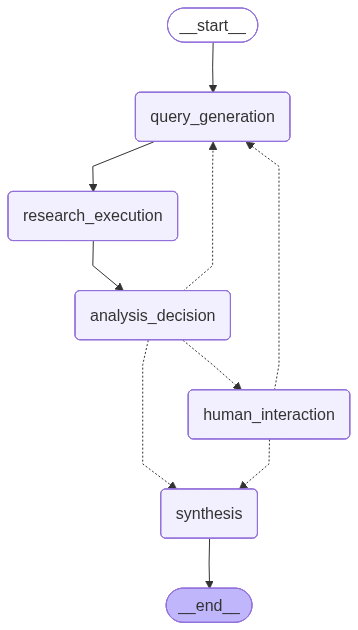

In [7]:
dynamic_app

## Test the DYNAMIC System

In [10]:
async def run_dynamic_research(user_question: str, max_iterations: int = 3):
    """Run the DYNAMIC research system with HUMAN-IN-THE-LOOP"""
    print("🚀 STARTING DYNAMIC LANGGRAPH RESEARCH WITH HUMAN-IN-THE-LOOP")
    print("="*80)
    print(f"🎯 User Question: {user_question}")
    print(f"🔄 Max Iterations: {max_iterations}")
    print("📋 Queries generated DYNAMICALLY - no hardcoding!")
    print("🤖 Human interaction triggered after 3 iterations!")
    print("="*80)
    
    if not vector_store:
        print("❌ Cannot run - vector store not available")
        return None
    
    # Initialize DYNAMIC state with human-in-the-loop fields
    initial_state = DynamicState(
        messages=[SystemMessage(content="You are an expert research assistant that dynamically generates queries based on user input and research findings.")],
        user_question=user_question,
        current_research_focus="",
        generated_queries=[],
        query_generation_reasoning=[],
        rag_findings=[],
        web_findings=[],
        information_gaps=[],
        next_research_strategy="",
        research_iteration=1,
        max_iterations=max_iterations,
        synthesized_answer="",
        confidence_score=0.0,
        decision_log=[],
        state_transitions=[],
        # Human-in-the-loop fields
        human_in_loop=False,
        human_queries=[],
        human_decision=""
    )
    
    print(f"\n📊 Initial State:")
    print(f"   User Question: {user_question}")
    print(f"   Max Iterations: {max_iterations}")
    print(f"   Strategy: FULLY DYNAMIC with HUMAN-IN-THE-LOOP")
    
    # Run the DYNAMIC workflow
    print(f"\n🔄 Executing DYNAMIC workflow with human interaction...")
    final_state = await dynamic_app.ainvoke(initial_state)
    
    return final_state

# Test with different questions
test_questions = [
    "What are Fabrinet's automotive products?",
    # "How many countries does Fabrinet operate in?",
    # "What is Fabrinet's revenue from telecom sector?"
]

# Let's test with the automotive question
test_question = test_questions[0]  # "What are Fabrinet's automotive products?"
print(f"🧪 Testing question: {test_question}")

# Note: This will trigger human interaction after 3 iterations
# For demonstration, you can use max_iterations=2 to avoid human interaction
final_state = await run_dynamic_research(test_question, max_iterations=2)

🧪 Testing question: What are Fabrinet's automotive products?
🚀 STARTING DYNAMIC LANGGRAPH RESEARCH WITH HUMAN-IN-THE-LOOP
🎯 User Question: What are Fabrinet's automotive products?
🔄 Max Iterations: 2
📋 Queries generated DYNAMICALLY - no hardcoding!
🤖 Human interaction triggered after 3 iterations!

📊 Initial State:
   User Question: What are Fabrinet's automotive products?
   Max Iterations: 2
   Strategy: FULLY DYNAMIC with HUMAN-IN-THE-LOOP

🔄 Executing DYNAMIC workflow with human interaction...

🧠 NODE 1: DYNAMIC QUERY GENERATION
🎯 User Question: What are Fabrinet's automotive products?
🔄 Research Iteration: 1
📊 Previous Findings: 0 characters

🧠 Generating queries for: 'What are Fabrinet's automotive products?' (iteration 1)
🎯 Generated 19 dynamic queries:
   1. <think>
   2. Okay, the user wants me to generate 3-4 specific search queries about Fabrinet's automotive products. Let me start by understanding the requirements. The rules say the queries need to be specific and search-fr

## Show Dynamic Results

In [11]:
if final_state:
    print("\n" + "="*80)
    print("🎉 DYNAMIC RESEARCH COMPLETED")
    print("="*80)
    
    # Show final answer
    print("\n📄 FINAL ANSWER:")
    print("-"*40)
    print(final_state["synthesized_answer"])
    
    # Show DYNAMIC query generation
    print("\n" + "="*80)
    print("🧠 DYNAMIC QUERY GENERATION TRACKING")
    print("="*80)
    
    print(f"\n📋 User Question: {final_state['user_question']}")
    print(f"🔄 Total Iterations: {final_state['research_iteration'] - 1}")
    
    for i, reasoning in enumerate(final_state['query_generation_reasoning'], 1):
        print(f"\n🎯 Iteration {i} Reasoning:")
        print(f"   {reasoning}")
    
    # Show all DYNAMIC queries
    print(f"\n🔍 ALL DYNAMIC QUERIES GENERATED:")
    all_queries = []
    for finding in final_state['rag_findings']:
        iteration = finding['iteration']
        for query in finding['queries']:
            all_queries.append(f"Iteration {iteration}: {query}")
    
    for i, query in enumerate(all_queries, 1):
        print(f"   {i}. {query}")
    
    print(f"\n📊 Total Dynamic Queries: {len(all_queries)}")
    
    # Show decision log
    print(f"\n📋 DECISION LOG:")
    for i, decision in enumerate(final_state['decision_log'], 1):
        print(f"   {i}. {decision}")
    
    # Show state transitions
    print(f"\n🔄 STATE TRANSITIONS:")
    for i, transition in enumerate(final_state['state_transitions'], 1):
        print(f"   {i}. {transition}")
    
    # Show information gaps
    if final_state['information_gaps']:
        print(f"\n🕳️ INFORMATION GAPS IDENTIFIED:")
        for gap in final_state['information_gaps']:
            print(f"   • {gap}")
    else:
        print(f"\n✅ NO INFORMATION GAPS - Research Complete!")
    
    print(f"\n📈 FINAL METRICS:")
    print(f"   Total RAG findings: {len(final_state['rag_findings'])}")
    print(f"   Total web findings: {len(final_state['web_findings'])}")
    print(f"   Final answer length: {len(final_state['synthesized_answer'])} characters")
    print(f"   Confidence score: {final_state['confidence_score']}")
    
    print(f"\n🎯 KEY ACHIEVEMENT:")
    print(f"   ✅ ZERO hardcoded queries")
    print(f"   ✅ FULLY dynamic query generation")
    print(f"   ✅ State-driven research decisions")
    print(f"   ✅ Intelligent gap analysis")
    print(f"   ✅ Adaptive research strategy")
    
else:
    print("❌ No final state to display")

print("---------------")
print("Final Answer:", final_state['synthesized_answer'].split('</think>')[1])


🎉 DYNAMIC RESEARCH COMPLETED

📄 FINAL ANSWER:
----------------------------------------
<think>
Okay, the user is asking about Fabrinet's automotive products. Let me start by recalling the research data provided. The search queries generated were about product lists, electric vehicle components, connectors and sensors, and product catalogs. The results from the web research mention partnerships with companies like Cepton and Innoviz Technologies, which might indicate that Fabrinet is involved in lidar and other automotive technologies.

First, I need to structure the answer to directly address the question. The user wants a comprehensive answer, so I should cover different product categories. From the search results, Fabrinet is mentioned as a global leader in precision optical, electronic, and mechanical components. Their automotive products likely include things like connectors, sensors, and components for electric vehicles.

The partnership with Cepton and Innoviz suggests they migh

## 🎯 Summary: DYNAMIC System with HUMAN-IN-THE-LOOP

### ✅ What Makes This DIFFERENT:

1. **🚫 ZERO HARDCODING** - No pre-programmed queries anywhere
2. **🧠 DYNAMIC Generation** - Queries created based on user input
3. **🔄 Adaptive Research** - Each iteration refines based on findings
4. **📊 Gap Analysis** - System identifies what's missing
5. **🎯 Intelligent Decisions** - State determines when to stop
6. **🤖 HUMAN-IN-THE-LOOP** - Human interaction after 3 tries!

### 🔍 How It Works:

1. **User asks**: "What are Fabrinet's automotive products?"
2. **System generates**: Initial search queries based on the question
3. **Research executes**: Uses those dynamic queries
4. **Analysis identifies**: What information is still missing
5. **Next iteration**: Generates refined queries for gaps
6. **🤖 AFTER 3 TRIES**: Human sees ALL previous queries and results
7. **Human can**: 
   - Add specific queries
   - Proceed to synthesis
   - Continue automatic research
8. **System continues**: Based on human decision

### 🎓 Interview Skills Demonstrated:

- **Dynamic Query Generation**: LLM creates search strategies
- **State-Driven Decisions**: System decides when to continue/stop
- **Gap Analysis**: Intelligent identification of missing information
- **Adaptive Workflows**: Research evolves based on findings
- **Advanced LangGraph**: Conditional edges and complex state management
- **Human-in-the-Loop Integration**: Interactive decision points

### 🤖 Human Interaction Features:

1. **Comprehensive Summary**: Shows all queries tried and results obtained
2. **Information Gaps**: Identifies what's still missing
3. **Flexible Options**: 
   - Add specific queries (comma-separated)
   - Proceed to synthesis with current findings
   - Continue automatic research
   - Get detailed status/preview

### 🚀 To Test Human-in-the-Loop:

```python
# This will trigger human interaction after 3 iterations
final_state = await run_dynamic_research("What are Fabrinet's automotive products?", max_iterations=4)

# Or test without human interaction
final_state = await run_dynamic_research("What are Fabrinet's automotive products?", max_iterations=2)
```

**🚀 This is a REAL intelligent system with human collaboration - not just automated!**

You can ask ANY question, the system will dynamically generate queries, research it, and THEN involve you in the decision-making process!

## 🎯 Summary: DYNAMIC System with HUMAN-IN-THE-LOOP

### ✅ What Makes This DIFFERENT:

1. **🚫 ZERO HARDCODING** - No pre-programmed queries anywhere
2. **🧠 DYNAMIC Generation** - Queries created based on user input
3. **🔄 Adaptive Research** - Each iteration refines based on findings
4. **📊 Gap Analysis** - System identifies what's missing
5. **🎯 Intelligent Decisions** - State determines when to stop
6. **🤖 HUMAN-IN-THE-LOOP** - Human interaction after research tries!

### 🔍 How It Works:

1. **User asks**: "What are Fabrinet's automotive products?"
2. **System generates**: Initial search queries based on the question
3. **Research executes**: Uses those dynamic queries
4. **Analysis identifies**: What information is still missing
5. **🤖 AFTER 1 TRY (testing)**: Human sees ALL previous queries and results
6. **Human can**: 
   - Add specific queries
   - Proceed to synthesis
   - Continue automatic research
7. **System continues**: Based on human decision

### 🎓 Interview Skills Demonstrated:

- **Dynamic Query Generation**: LLM creates search strategies
- **State-Driven Decisions**: System decides when to continue/stop
- **Gap Analysis**: Intelligent identification of missing information
- **Adaptive Workflows**: Research evolves based on findings
- **Advanced LangGraph**: Conditional edges and complex state management
- **Human-in-the-Loop Integration**: Interactive decision points

### 🤖 Human Interaction Features:

1. **Comprehensive Summary**: Shows all queries tried and results obtained
2. **Information Gaps**: Identifies what's still missing
3. **Flexible Options**: 
   - Add specific queries (comma-separated)
   - Proceed to synthesis with current findings
   - Continue automatic research
   - Get detailed status/preview

### 🚀 To Test Human-in-the-Loop:

**🧪 TESTING MODE:** System now triggers human interaction after **1 iteration** (for testing)

```python
# This will trigger human interaction immediately after first research round
final_state = await run_dynamic_research("What are Fabrinet's automotive products?", max_iterations=3)

# Test with any question - human interaction will trigger after first round
final_state = await run_dynamic_research("How many countries does Fabrinet operate in?", max_iterations=2)
```

**🎯 What happens during human interaction:**

1. **Research Summary**: Shows all queries tried and results found
2. **Your Options**:
   - Type `synthesize` → Create final answer with current findings
   - Type `continue` → Let AI continue researching automatically  
   - Type `specific query, another query` → Add your own search queries
   - Type `help` → See all available commands

**📝 Example Interaction:**
```
👤 Your choice: Fabrinet revenue breakdown, Fabrinet automotive partnerships
👤 Your choice: synthesize  
👤 Your choice: continue
```

### 🔧 To Reset to Original Behavior:

Change line in `analysis_decision_node`:
```python
# From: if current_iteration >= 1:  # Testing mode
# To:   if current_iteration >= 3:  # Original behavior
```

**🚀 This is a REAL intelligent system with human collaboration - not just automated!**

You can ask ANY question, the system will dynamically generate queries, research it, and THEN involve you in the decision-making process!